# Recommendation Engine Development (ML)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
import json
import re
import sys
import warnings
import pickle
import h5py
from scipy import sparse
import copy

# Scraping data
from bs4 import BeautifulSoup
import requests
import random
import datetime

# ML import packages
# Imputation and Data Preparation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, normalize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor

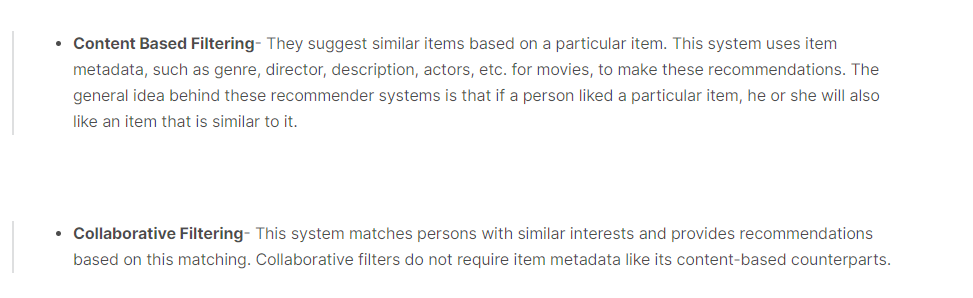

# Data Import 

In [2]:
# IMDB movies

movies_df = pd.read_csv('raw_data/IMDB movies.csv', low_memory=False)

print('Movies shape:', movies_df.shape)
movies_df.head(7)

Movies shape: (85855, 22)


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0
5,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,1913,"Biography, Drama",60,USA,English,Sidney Olcott,...,"R. Henderson Bland, Percy Dyer, Gene Gauntier,...","An account of the life of Jesus Christ, based ...",5.7,484,NaN,NaN,NaN,NaN,13.0,5.0
6,tt0002423,Madame DuBarry,Madame DuBarry,1919,1919-11-26,"Biography, Drama, Romance",85,Germany,German,Ernst Lubitsch,...,"Pola Negri, Emil Jannings, Harry Liedtke, Edua...","The story of Madame DuBarry, the mistress of L...",6.8,753,NaN,NaN,NaN,NaN,12.0,9.0


In [3]:
movies_df.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

In [4]:
movies_df = movies_df.drop(['worlwide_gross_income', 'metascore', 'usa_gross_income'], axis=1)
print('Movies shape:', movies_df.shape)

Movies shape: (85855, 19)


In [5]:
movies_df_orig = movies_df.copy()

# Data investigation

In [6]:
movies_df.isnull().sum()

imdb_title_id               0
title                       0
original_title              0
year                        0
date_published              0
genre                       0
duration                    0
country                    64
language                  833
director                   87
writer                   1572
production_company       4455
actors                     69
description              2115
avg_vote                    0
votes                       0
budget                  62145
reviews_from_users       7597
reviews_from_critics    11797
dtype: int64

In [7]:
# Unique values in categorical data

for x in movies_df.columns:
    print(x, ':', movies_df[x].nunique())

imdb_title_id : 85855
title : 82094
original_title : 80852
year : 113
date_published : 22012
genre : 1257
duration : 266
country : 4907
language : 4377
director : 34733
writer : 66859
production_company : 32050
actors : 85729
description : 83611
avg_vote : 89
votes : 14933
budget : 4642
reviews_from_users : 1213
reviews_from_critics : 595


<AxesSubplot:title={'center':'Heatmap correlations'}>

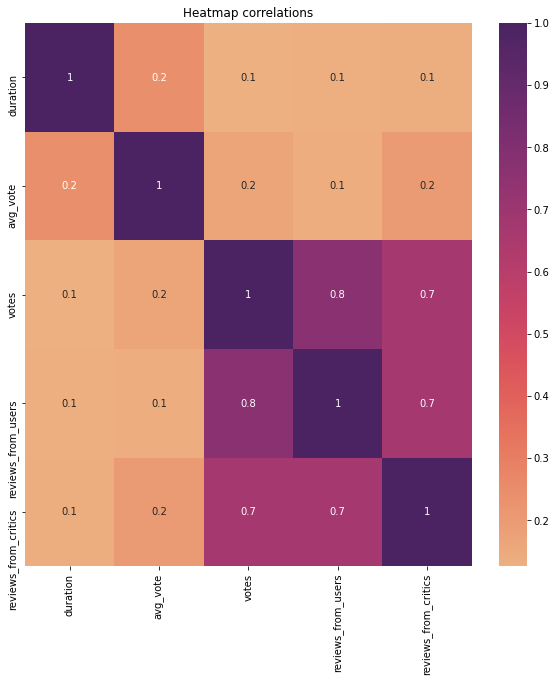

In [8]:
# Correlation Heatmap

def heatmap_plot(dataframe, title):
    plt.figure(figsize=(10,10))
    hm = sns.heatmap(dataframe.corr(), annot=True, fmt='.1g', cmap='flare')
    plt.title(str(title))
    
    return hm

heatmap_plot(movies_df, 'Heatmap correlations')

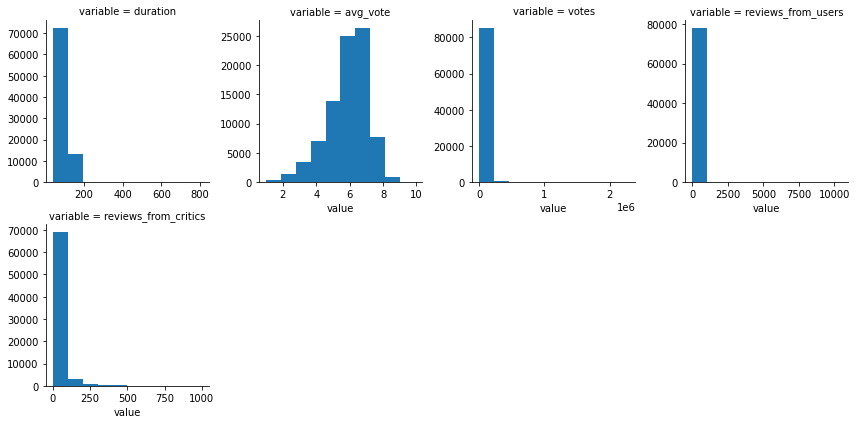

In [9]:
# Plot data distributions

def distribution_plotting(dataframe):
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    n_cols = dataframe.select_dtypes(include=numerics).columns
    
    f = pd.melt(dataframe, value_vars=n_cols) 
    facetgrid = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
    facetgrid = facetgrid.map(plt.hist, 'value')
    return facetgrid

distribution_plotting(movies_df)

# Data Cleaning, Preprocessing & Feature Engineering

# 1. Imputation missing values

In [10]:
# Remove missing values in actors, country and director 

movies_df.dropna(subset=['actors', 'director', 'country', 'description'], inplace=True)

In [11]:
# Remove useless columns for predictions 

movies_df = movies_df.drop(['budget', 'title', 'date_published', 'reviews_from_critics', 'writer', 'production_company'], axis=1)

In [12]:
# Imputation with m. frequent values 

ffeatures = ['language']

impt = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
movies_df[ffeatures] = pd.DataFrame(impt.fit_transform(movies_df[ffeatures]), columns=movies_df[ffeatures].columns, index=movies_df[ffeatures].index)

# Fill reviews from users with mean values 
movies_df.reviews_from_users = movies_df.reviews_from_users.replace(np.NaN, movies_df.reviews_from_users.mean())

In [13]:
# Check for missing values again

movies_df.isnull().sum()

imdb_title_id         0
original_title        0
year                  0
genre                 0
duration              0
country               0
language              0
director              0
actors                0
description           0
avg_vote              0
votes                 0
reviews_from_users    0
dtype: int64

# 2. Data Preparation

In [14]:
# Reset index after cleaning rows

movies_df.reset_index(drop=True, inplace=True)

In [15]:
# Description Cleaning
stop_words = set(stopwords.words('english'))

def remove_characters(text):
    return re.sub(r'[^a-zA-Z0-9 \n\.]', '', text)

def to_lower(text):
    return text.lower()

def replace_umlaute(text):
    return text.replace('ü', 'ue').replace('ä', 'ae').replace('ö', 'oe').replace('ß', 'ss')

def to_word_tokens(text):
    return word_tokenize(text)

def text_lemmatize(text):
    
    """ Important to investigate the origin language of text value --> german/english/french/spanish etc.
    For lemmatization purposes. """
    
    wnl = WordNetLemmatizer()
    
    return [wnl.lemmatize(x) for x in text]
    

def remove_stopwords(text):
    pure_text = []
    for i in text:
        if i.lower().strip() not in stop_words and i.strip().lower().isalpha():
            pure_text.append(i.lower())
    return " ".join(pure_text)


def text_cleaning(text):
    
    text = replace_umlaute(text)
    text = to_lower(text)
    text = remove_characters(text)
    text = to_word_tokens(text)
    text = text_lemmatize(text)
    text = remove_stopwords(text)
    
    return text

In [16]:
# Testing text cleaning

testnumber = 5

print('Before:', movies_df.description.iloc[testnumber], '\n')
movies_df.description = movies_df.description.apply(text_cleaning)
print('After:', movies_df.description.iloc[testnumber])

Before: An account of the life of Jesus Christ, based on the books of the New Testament: After Jesus' birth is foretold to his parents, he is born in Bethlehem, and is visited by shepherds and wise... 

After: account life jesus christ based book new testament jesus birth foretold parent born bethlehem visited shepherd wise


In [17]:
print('After:', movies_df.description.iloc[12501])

After: everyone want know mexican always answer slowly name pecos pecos martinez robert wood exact returned hometown houston settle


In [18]:
# Data types quality improvement

movies_df[['genre', 'country']] = movies_df[['genre', 'country']].astype('category')
movies_df.avg_vote = movies_df.avg_vote.astype('float32')

movies_df.dtypes

imdb_title_id           object
original_title          object
year                    object
genre                 category
duration                 int64
country               category
language                object
director                object
actors                  object
description             object
avg_vote               float32
votes                    int64
reviews_from_users     float64
dtype: object

In [19]:
# Unique values in the data

for x in movies_df.columns:
    print(x, ':', movies_df[x].nunique())

imdb_title_id : 83549
original_title : 78629
year : 113
genre : 1244
duration : 264
country : 4852
language : 4339
director : 34012
actors : 83509
description : 83383
avg_vote : 89
votes : 14916
reviews_from_users : 1214


In [20]:
# Concatenating Name + Surname in actors & directors

movies_df['actors'] = movies_df['actors'].str.replace(' ', '')
movies_df['actors'] = movies_df['actors'].str.replace(',', ', ')

movies_df['director'] = movies_df['director'].str.replace(' ', '')
movies_df['director'] = movies_df['director'].str.replace(',', ', ')

<AxesSubplot:title={'center':'Heatmap correlations'}>

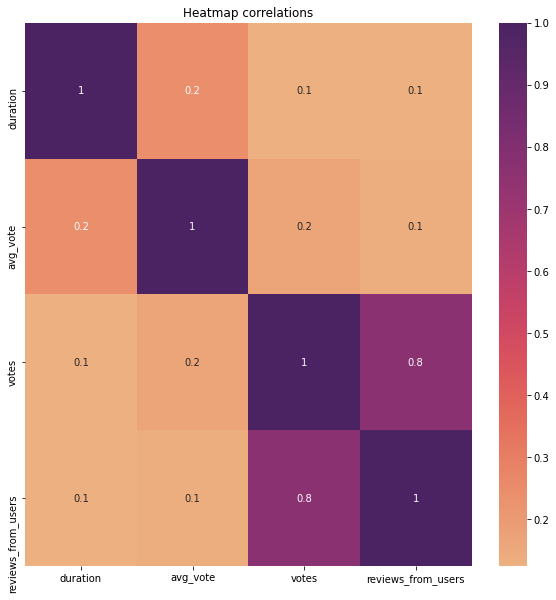

In [21]:
heatmap_plot(movies_df, 'Heatmap correlations')

# • Cosine Similarity (Feature Engineering Text)


In [22]:
# Text data cleaning

movies_df['genre'] = movies_df['genre'].apply(text_cleaning)
movies_df['country'] = movies_df['country'].apply(text_cleaning)
movies_df['director'] = movies_df['director'].apply(text_cleaning)
movies_df['actors'] = movies_df['actors'].apply(text_cleaning)
movies_df['language'] = movies_df['language'].apply(text_cleaning)

In [23]:
# Write the movies_df to CSV file

movies_df.to_csv('raw_data/movies_clean_df.csv')

In [24]:
# Filtering dataset only by text features & combining them

text_features = ['genre', 'country', 'director', 'actors', 'description']

def combined_features(row):
    return row['genre']+" "+row['country']+" "+row['director']+" "+row['actors']+" "+row['description']

movies_df['combined_features'] = movies_df.apply(combined_features, axis=1)
movies_df.tail()

,imdb_title_id,original_title,year,genre,duration,country,language,director,actors,description,avg_vote,votes,reviews_from_users,combined_features
83544,tt9905462,Pengalila,2019,drama,111,india,malayalam,,lal aksharakishor iniya narain renjipanicker i...,unusual bond sixty year old dalit worker azhag...,8.8,553,46.751031,drama india lal aksharakishor iniya narain re...
83545,tt9906644,Manoharam,2019,comedy drama,122,india,malayalam,anvarsadik,vineethsreenivasan aparnadas basiljoseph indra...,manoharan poster artist struggling find respec...,6.8,491,9.000000,comedy drama india anvarsadik vineethsreenivas...
83546,tt9908390,Le lion,2020,comedy,95,france belgium,french,ludoviccolbeaujustin,danyboon philippekaterine anneserra samueljouy...,psychiatric hospital patient pretend crazy cha...,5.3,398,46.751031,comedy france belgium ludoviccolbeaujustin dan...
83547,tt9911196,De Beentjes van Sint-Hildegard,2020,comedy drama,103,netherlands,german dutch,johannijenhuis,hermanfinkers johannatersteege leonieterbraak ...,middleaged veterinary surgeon belief wife pamp...,7.7,724,6.000000,comedy drama netherlands johannijenhuis herman...
83548,tt9914942,La vida sense la Sara Amat,2019,drama,74,spain,catalan,laurajou,mariamoreracolomer bielrossellpelfort isaacalc...,pep boy love girl grandparent village sara ama...,6.7,102,46.751031,drama spain laurajou mariamoreracolomer bielro...


# • Recommendation engine w. Cosine Similarity (CS)

In [25]:
# Converting combined text features to vectors

cv = CountVectorizer(min_df=20, dtype='int8')
cv_matrix = cv.fit_transform(movies_df['combined_features'])
cvm_a = cv_matrix.toarray().astype('int8')
print('cv_matrix shape:', cv_matrix.shape)
print("Number of unique columns in vectorized feature:", cv_matrix.shape[1])

cv_matrix shape: (83549, 14842)
Number of unique columns in vectorized feature: 14842


In [37]:
# HELPER functions

def get_title_from_index(index):
    return movies_df[movies_df.index == index]["original_title"].values[0]

def get_avg_vote_from_index(index):
    return movies_df[movies_df.index == index]["avg_vote"].values[0]

def get_votes_from_index(index):
    return movies_df[movies_df.index == index]["votes"].values[0]

def get_index_from_title(title):
    return movies_df[movies_df.original_title == title].index[0]

def get_imdb_id_from_index(index):
    return movies_df[movies_df.index == index]['imdb_title_id'].values[0]

def top25_movies_df(top5_movies):
    ids = [x[0] for x in top5_movies]
    return movies_df[movies_df.index.isin(ids)]

def similarity_a_chunk(movie_index, start, end):
    if end > cvm_a.shape[0]:
        end = cvm_a.shape[0]
    return cosine_similarity(cvm_a[movie_index, None, :], cvm_a[start:end].astype('float32'))

In [27]:
# Recommendation function with chunks

def recommend_movies(title):
    
    print('Searching...\n\n')
    start = datetime.datetime.now()
    
    # Similarity array
    final_chunks = []
    chunk_size = 10000
    movie_index = get_index_from_title(title)

    for chunk_start in range(0, cvm_a.shape[0], chunk_size):
        cos_sim_chunk = similarity_a_chunk(movie_index, chunk_start, chunk_start+chunk_size).astype('float32')[0]
        final_chunks.extend(cos_sim_chunk)
        
    # Sorting movies
    similar_movies = list(enumerate(final_chunks))
    sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)
                
    end = datetime.datetime.now()
    print('Runtime:', end-start)
    
    return sorted_similar_movies[:25]
            
top25 = recommend_movies('Le lion')
top25 = [list(x) for x in top25]

# Top 5 movies with cosine similarity score

print('\n5 most similar movies:')
i=0
for x in top25[1:]:
    print(i+1, ': (ID)', x[0], ':', get_title_from_index(x[0]), ':', round(x[1] * 100, 2), '%')
    i=i+1
    if i>4:
        break

Searching...


Runtime: 0:00:52.745827

5 most similar movies:
1 : (ID) 81952 : Tutsak : 34.11 %
2 : (ID) 72664 : 55 Steps : 28.72 %
3 : (ID) 12593 : La lama nel corpo : 28.49 %
4 : (ID) 33486 : Maniac Nurses : 28.49 %
5 : (ID) 83434 : C'est quoi cette mamie?! : 28.43 %


# • CS + Weighted Rating (WR)

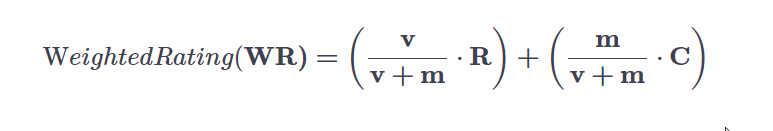

In [28]:
# Extendig top25 list with votes and rating --> Index, Cosine Similarity, Rating, Votes

for a in top25:
    a.append(get_avg_vote_from_index(a[0]))
    a.append(get_votes_from_index(a[0]))

In [29]:
# Add weighted rating to every movie in top25

def recommend_movies_wr(top25list):
    
    top25_wr = copy.deepcopy(top25) # Copying list of list with deepcopy! (normal copy produces error)  

    # Calculation C
    C = []
    for x in top25_wr:
        C.append(x[2])
    C = np.mean(C)

    # Calculation m
    m = []
    for x in top25_wr:
        m.append(x[3])
    m = np.quantile(m, q=0.95)

    # Weighted Rating Add-On algorithm
    for film in top25_wr:
        weighted_rating = round((film[3]/(film[3] + m)*film[2]) + (m/(m+film[3]) * C), 5)
        film.append(weighted_rating)

    sorted_top25_wr = sorted(top25_wr, key=lambda x:x[4], reverse=True)
    return sorted_top25_wr

top25_weighted_rating = recommend_movies_wr(top25)

print('\n5 most similar movies with WR:')
i=0
for x in top25_weighted_rating:
    if x[1] == 1: # Skipping movie itself
        continue
    else:
        print(i+1, ': (ID)', x[0], ':', get_title_from_index(x[0]), 'with CS:', round(x[1] * 100, 2), '%.', 'WR:', x[4])
        i=i+1
        if i>4:
            break


5 most similar movies with WR:
1 : (ID) 38675 : K-PAX with CS: 24.17 %. WR: 7.31841
2 : (ID) 22364 : Hombre mirando al sudeste with CS: 26.97 %. WR: 6.46437
3 : (ID) 79369 : Aritmiya with CS: 26.65 %. WR: 6.44201
4 : (ID) 57416 : Rien à déclarer with CS: 23.84 %. WR: 6.24575
5 : (ID) 72664 : 55 Steps with CS: 28.72 %. WR: 6.19228


# • CS + WR + WR Contribution Hyperparameter

In [44]:
# Combining cosine similarity and weighted rating

def recommend_movies_10(title, csq=1, wrq=1):
    
    """ 
    Recommend 10 movies function:
        q {0;1} == Hyperparameter to optimize the rating influence in the calculataion of final score
        0 --> no influence
        1 --> full rating influence     
    """
    
    print('Searching...\n')
    start = datetime.datetime.now()
    
    # +++++ COSINE SIMILARITY +++++
    final_chunks = []
    chunk_size = 10000
    movie_index = get_index_from_title(title)

    for chunk_start in range(0, cvm_a.shape[0], chunk_size):
        cos_sim_chunk = similarity_a_chunk(movie_index, chunk_start, chunk_start+chunk_size).astype('float32')[0]
        final_chunks.extend(cos_sim_chunk)
        
    # Sorting CS movies
    similar_movies = list(enumerate(final_chunks))
    sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)[:15] 
    sorted_similar_movies = [list(x) for x in sorted_similar_movies]
    
    # Adding votes & rating to every movie in top15
    for a in sorted_similar_movies:
        a.append(get_avg_vote_from_index(a[0]))
        a.append(get_votes_from_index(a[0]))
    
    
    # +++++ WEIGHTED RATING +++++
    top15_wr = copy.deepcopy(sorted_similar_movies) # Copying list of list with deepcopy! (normal copy produces error)  

    # Calculation C
    C = []
    for x in top15_wr:
        C.append(x[2])
    C = np.mean(C)

    # Calculation m
    m = []
    for x in top15_wr:
        m.append(x[3])
    m = np.quantile(m, q=0.65)
    
    # List with WR
    WR = []
    
    # Weighted Rating Add-On algorithm + Final score
    for film in top15_wr:
        weighted_rating = round((film[3] * film[2]/(film[3] + m)) + (m * C/(m+film[3])), 3)
        WR.append(weighted_rating)
        film.append(weighted_rating)
    
    for film in top15_wr:
        WR_norm = round((film[4] - min(WR)) / (max(WR) - min(WR)), 3)
        final_score = round(((film[1] * csq) + (WR_norm * wrq)), 3)
        film.append(final_score)
        film.append(get_imdb_id_from_index(film[0]))
    
    sorted_top15_wr = sorted(top15_wr, key=lambda x:x[5], reverse=True)
    end = datetime.datetime.now()
    print('Runtime:', end-start)
    
    return sorted_top15_wr

In [52]:
# Recommendations

recommendations = recommend_movies_10('The Dark Knight Rises', csq=0.9, wrq=0.1)

print('\n5 most similar movies with WR:')
i=0
for x in recommendations:
    if x[1] == 1:
        continue
    else:
        print(i+1, ':', get_title_from_index(x[0]), 'CS:', x[1], 'Score:', x[5])
        i=i+1
        if i>15:
            break

Searching...

Runtime: 0:00:28.311417

5 most similar movies with WR:
1 : Batman Begins CS: 0.3666178 Score: 0.4
2 : The Dark Knight CS: 0.2857503 Score: 0.357
3 : Inception CS: 0.281788 Score: 0.346
4 : The Incredibles CS: 0.23515855 Score: 0.269
5 : Wastelander CS: 0.2715377 Score: 0.256
6 : Unmasking the Idol CS: 0.24906774 Score: 0.236
7 : King Arthur: Legend of the Sword CS: 0.2419554 Score: 0.236
8 : Batman and Harley Quinn CS: 0.24722569 Score: 0.234
9 : Lichnyy nomer CS: 0.2409658 Score: 0.228
10 : Clash of the Titans CS: 0.22450663 Score: 0.217
11 : The Adventures of Sharkboy and Lavagirl 3-D CS: 0.24000768 Score: 0.216
12 : Pilgrim's Progress CS: 0.22718473 Score: 0.216
13 : Batman: Return of the Caped Crusaders CS: 0.22470176 Score: 0.214
14 : Air Marshal CS: 0.22450663 Score: 0.213


In [53]:
recommendations

[[55642, 1.0, 8.4, 1480582, 8.11, 0.977, 'tt1345836'],
 [42907, 0.3666178, 8.2, 1278075, 7.902, 0.4, 'tt0372784'],
 [46864, 0.2857503, 9.0, 2241615, 8.743, 0.357, 'tt0468569'],
 [55876, 0.281788, 8.8, 2002816, 8.536, 0.346, 'tt1375666'],
 [40920, 0.23515855, 8.0, 642759, 7.539, 0.269, 'tt0317705'],
 [66288, 0.2715377, 2.6, 164, 6.264, 0.256, 'tt2651724'],
 [35477, 0.24906774, 5.1, 140, 6.266, 0.236, 'tt0202046'],
 [61729, 0.2419554, 6.7, 187078, 6.46, 0.236, 'tt1972591'],
 [78630, 0.24722569, 5.9, 11064, 6.25, 0.234, 'tt6556890'],
 [44639, 0.2409658, 5.3, 577, 6.264, 0.228, 'tt0415940'],
 [19631, 0.22450663, 6.9, 40160, 6.36, 0.217, 'tt0082186'],
 [45062, 0.24000768, 3.5, 30917, 5.942, 0.216, 'tt0424774'],
 [50848, 0.22718473, 6.2, 303, 6.267, 0.216, 'tt1000768'],
 [77089, 0.22470176, 6.8, 4566, 6.277, 0.214, 'tt5973626'],
 [40950, 0.22450663, 2.6, 497, 6.259, 0.213, 'tt0318281']]

# Sentiment Analysis on movie reviews

In [111]:
# Scraping reviews for every movie in recommendations (top10)

reviews = {}
url = 'https://www.imdb.com/title/{movieid}/reviews'
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36'}


for movie in recommendations[:10]:
    response = requests.get(url.format(movieid=movie[6]), headers=header)
    site = BeautifulSoup(response.text, features='html.parser')
    content = list(site.find_all('div', {'class': 'content'}))
    
    for rev in content:
        review = rev.find('div', {'class': 'text show-more__control'})
        reviews.setdefault(movie[6], []).append(review.text) 

{'tt1345836': ['After eight years in seclusion, Batman resurfaces to face Bane, a mastermind bent on destroying Gotham and has ties to Bruce Wayne\'s past. Christopher Nolan\'s conclusion to his Dark Knight trilogy should be treated as a wrap up rather than a third installment. Despite many new characters being introduced, even their conflicts and motives are derived from events that occurred in the previous two films. Such an approach could be seen as a weakness, since the conflict could just end up being sort of a rematch rather than moving the story forward; however, Nolan\'s approach works terrificly. Over an hour is shot in stunning IMAX, but the film is more touching than it is intense\x85 and that\'s its best quality. Hardy steps in as the genius mercenary Bane, who is slightly bigger, slightly stronger and slightly smarter than Batman, thus making him a challenge best suited for the grand finale. The Joker works best as Batman\'s arch-nemesis since they are polar opposites, wit

In [119]:
for k,v in reviews.items():
    print(k, ':', v, '\n')

tt1345836 : ['After eight years in seclusion, Batman resurfaces to face Bane, a mastermind bent on destroying Gotham and has ties to Bruce Wayne\'s past. Christopher Nolan\'s conclusion to his Dark Knight trilogy should be treated as a wrap up rather than a third installment. Despite many new characters being introduced, even their conflicts and motives are derived from events that occurred in the previous two films. Such an approach could be seen as a weakness, since the conflict could just end up being sort of a rematch rather than moving the story forward; however, Nolan\'s approach works terrificly. Over an hour is shot in stunning IMAX, but the film is more touching than it is intense\x85 and that\'s its best quality. Hardy steps in as the genius mercenary Bane, who is slightly bigger, slightly stronger and slightly smarter than Batman, thus making him a challenge best suited for the grand finale. The Joker works best as Batman\'s arch-nemesis since they are polar opposites, with 

# IDEAS

1. Add more movies from IMDB (WebScraping)
2. Remove document frequency limitation from Vectorizer
3. Remove words "movie, film, etc." from description feature --> possible bias in final recommendation
